In this notebook we give a proof of concept of unitary compiling using TFQ. 

In [78]:
%load_ext autoreload
%autoreload 2

import sympy 
import numpy as np 
import pandas as pd 
import tensorflow as tf
from utilities.circuit_database import CirqTranslater
from utilities.templates import *
from utilities.variational import Minimizer
import matplotlib.pyplot as plt 
import tensorflow_quantum as tfq
import cirq
from utilities.compiling import *
from utilities.misc import *
from utilities.simplifier import Simplifier
from utilities.discrimination import *
from utilities.idinserter import IdInserter
from utilities.evaluator import Evaluator
from utilities.gate_killer import GateKiller
from ast import literal_eval


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
np.random.seed(0)
translator = CirqTranslater(4, untouchable_blocks = [])

translator.env_qubits = [2]

simplifier = Simplifier(translator)
etas = [0.01, 1.]
minimizer = Minimizer(translator, mode="discrimination", params=etas)

In [47]:
q = 0
other_qs = list(range(translator.n_qubits))
other_qs.remove(q)
indds = [translator.cnots_index[str([q,k])] for k in other_qs]
cdb = pd.DataFrame([gate_template(i) for i in indds])

circuit_db = concatenate_dbs([z_layer_db(translator), cdb])

for q in range(1, translator.n_qubits):
    other_qs = list(range(translator.n_qubits))
    other_qs.remove(q)
    indds = [translator.cnots_index[str([q,k])] for k in other_qs]
    cdb = pd.DataFrame([gate_template(i) for i in indds])
    circuit_db = concatenate_dbs([circuit_db ,cdb])

c, circuit_db = translator.give_circuit(circuit_db)

In [48]:
db1 = concatenate_dbs([x_layer_db(translator)]*3)
db2 = concatenate_dbs([z_layer_db(translator)]*3)
db3 = concatenate_dbs([x_layer_db(translator)]*3)
db4 = concatenate_dbs([z_layer_db(translator)]*3)

In [49]:
circuit_db = concatenate_dbs([circuit_db, db1, db2,db3,db4])
c, circuit_db = translator.give_circuit(circuit_db)

In [51]:
cdb = []
for ind, qubits in list(translator.indexed_cnots.items()):
    cdb.append(gate_template(int(ind), block_id=0))
    con, tar = qubits
    cdb.append(gate_template(int(con + translator.number_of_cnots), param_value = np.random.random()))
    cdb.append(gate_template(int(tar + translator.number_of_cnots + translator.n_qubits), param_value = np.random.random()))
c6_db = pd.DataFrame(cdb)
circuit_db = concatenate_dbs([circuit_db, c6_db])

In [74]:
simplifier = Simplifier(translator, apply_relatives_to_first = False)
simplifier.apply_relatives_to_first = False
simplifier.absolute_rules =[ simplifier.rule_3]
simplified_db, ns = simplifier.reduce_circuit(circuit_db)
ss, simplified_db = translator.give_circuit(simplified_db)

<bound method Simplifier.rule_3 of <utilities.simplifier.Simplifier object at 0x7f0f77055588>>
<bound method Simplifier.rule_3 of <utilities.simplifier.Simplifier object at 0x7f0f77055588>>
<bound method Simplifier.rule_3 of <utilities.simplifier.Simplifier object at 0x7f0f77055588>>
<bound method Simplifier.rule_3 of <utilities.simplifier.Simplifier object at 0x7f0f77055588>>


In [75]:
check_symbols_ordered(simplified_db)

True

In [91]:
mdif, [u1,u2] = max_diff(translator , circuit_db, simplified_db, matrix=True)

In [95]:
import matplotlib.pyplot as plt 

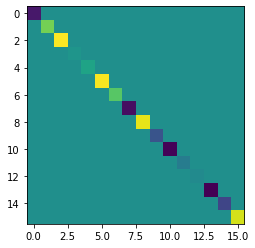

In [97]:
plt.imshow(np.real(a_bt(u1,u2)) )

In [102]:
np.abs(np.diag(np.real(a_bt(u1,u2)) + np.imag(a_bt(u1,u2))*1j))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [104]:
check_symbols_ordered(simplified_db)

True